In [ ]:
import numpy as np
import numpy.linalg as nl
import matplotlib.pyplot as plt
import groundTruthLocation as gtl

In [ ]:
def convert_train_data(file_name):
    # File content should be [b_i, rssi]
    #                        ..........
    # Convert it to dictionary dict[index_beacon] = [rss_1, ..., rssi_n]

    beacon_dict = {}
    with open(file_name, 'r') as packs:
        packs.readline()
        for pack in packs:
            pack = pack[0: len(pack) - 1]
            space_loc = pack.find(' ')
            beacon = pack[0: space_loc]
            ri = float(pack[space_loc + 1:])

            if beacon not in beacon_dict:
                beacon_dict[beacon] = [ri]
            else:
                beacon_dict[beacon].append(ri)

    return beacon_dict


In [ ]:
def get_state_location(file_name = 'standingLocation.csv'):
    # Assumption that metric in csv file is inch, multiply by 0.0254 to get meters.
    # Return state_loc[i][x,y], i is the i_th state, starting from 0.

    with open(file_name, 'r') as file:
        file_len = sum(1 for _ in file)

    with open(file_name, 'r') as file:
        state_loc = np.zeros((file_len, 2))
        for line in file:
            line = line[0:(len(line)-1)]
            splt = line.split(',')
            state_loc[int(splt[0])-1][0] = float(splt[1])
            state_loc[int(splt[0])-1][1] = float(splt[2])

    return 0.0254 * state_loc


In [ ]:
def convert_test_data(file_name):
    # file header should be [TimeStamp, Beacon, Rssi]
    # convert it to numpy array

    with open(file_name, 'r') as file:
        file_len = sum(1 for _ in file)

    with open(file_name) as file:
        file.readline() # remove the header
        data = np.zeros((file_len - 1, 3))
        for line, i in zip(file, range(file_len - 1)):
            line = line[0:(len(line)-1)]
            splt = line.split(' ')
            data[i][0] = float(splt[0])
            data[i][1] = int(splt[1])
            data[i][2] = float(splt[2])

    return data


In [ ]:
def get_alpha(beacon_dict, num_beacon = 60):
    # Returned alphas should be [alpha_b1, alpha_b2, ..., alpha_bn]
    # ssvs => signal strength values

    alphas = np.zeros(num_beacon)

    for beacon in beacon_dict:
        ssvs = np.array(beacon_dict[beacon])
        num_ssv = len(ssvs)

        shift_vec = np.arange(num_ssv - 1) + 1
        ssvs_shift = ssvs[shift_vec]
        ssvs_trunc = ssvs[0: len(ssvs) - 1]

        sbar = np.mean(ssvs)

        sumsq = np.sum((ssvs - sbar) ** 2)
        if sumsq == 0:   # Need discussion with subham
            r1 = 0
        else:
            r1 = abs(np.sum((ssvs_shift - sbar) * (ssvs_trunc - sbar))) / sumsq

        alphas[int(beacon) - 1] = r1

    return alphas

In [ ]:
def train(state_files, num_beacon = 60):
    # Get mu and sigma for each state, noted that here it's sigma instead of sigma square.
    # Return state_map[i][mu,sigma]

    num_state = len(state_files)
    state_map = np.zeros((num_state, num_beacon, 2))  # For beacons not in file, exclude them
    state_map[:,:,0] = -100
    state_map[:,:,1] = 1/3

    for file, si in zip(state_files, range(num_state)): # si represents state_index
        beacon_dict = convert_train_data(file)
        alphas = get_alpha(beacon_dict)   # Alphas => [alpha_b1, alpha_b2, ..., alpha_bn]

        for rssis in beacon_dict:  # rssis is beacon number
            alpha = alphas[int(rssis)-1]
            arr = beacon_dict[rssis]
            state_map[si][int(rssis)-1][0] = np.mean(arr)
            state_map[si][int(rssis)-1][1] = np.sqrt((1 + alpha) / (1 - alpha)*np.var(arr))

            if state_map[si][int(rssis)-1][1] == 0: # All rssis for one beacon are the same (var = 0)
                state_map[si][int(rssis) - 1][1] = 15
                #state_map[si][int(rssis) - 1][0] = -100  # Subtle!!! Depends on signal strength.

    return state_map


In [ ]:
def kl_process_cluster(cluster, num_beacon = 60):
    # Return mu and sigma of rssi for each beacon in each state.
    
    bs = np.empty(num_beacon, dtype=object)

    for i in range(num_beacon):
        bs[i] = []
    arg = np.argsort(cluster[:, 1])
    cluster = cluster[arg]

    for i in range(len(cluster)):
        bs[int(cluster[i][1]) - 1].append(cluster[i][2])

    res = []
    for arr in bs:
        if arr == []:
            res.append((0,0))
        else:
            res.append((np.mean(np.array(arr)), np.sqrt(np.var(np.array(arr)))))

    return np.array(res)

In [ ]:
def cluster_test_data(filename, num_beacon = 60, interval = 10):
    # Data should be numpy array
    # Return dictionary with d['i'] = [(beacon_1_mu, beacon_1_sigma), ..., (beacon_n_mu, beacon_n_sigma)], i represents state_i

    data = convert_test_data(filename)
    num_rows = data.shape[0]
    max_time = data[num_rows-1][0]

    num_cluster = int(max_time / interval)
    start_index = [0]
    d = {}

    for i in range(1, num_cluster + 1):
        thred = interval * i
        index = np.searchsorted(data[:,0], thred)
        start_index.append(index)

    for i in range(len(start_index) - 1):
        cluster = data[start_index[i]:start_index[i+1]]
        d[i] = kl_process_cluster(cluster)

    return d, max_time

In [ ]:
def test_kl(state_map, test_rssi, state_loc, index, jud):
    # KL(p, q), p is test_rssi, but the order makes no difference
    # See formula in the cell below.

    jud = 1 - jud
    kl_dist = []
    arg_zero = (abs(test_rssi[:,0]) > 1.0) * jud * (abs(test_rssi[:,1]) > 1.0)
    test_rssi[:,1][test_rssi[:,1] < 1] = 10

    for i in range(state_map.shape[0]):
        #map_mu, map_sigma = state_map[i][:, 0], state_map[i][:, 1]
        #test_mu, test_sigma = test_rssi[:,0], test_rssi[:,1]

        map_mu, map_sigma = test_rssi[:,0], test_rssi[:,1]
        test_mu, test_sigma = state_map[i][:, 0], state_map[i][:, 1]

        cur_dist = np.sum(arg_zero * (np.log(map_sigma / test_sigma) - 1/2)) + \
                   np.sum(arg_zero * (test_sigma ** 2 + (test_mu - map_mu) ** 2)/(2 * map_sigma ** 2))
        kl_dist.append(cur_dist)

    probs = np.zeros(state_loc.shape[0])
    iter = np.arange(state_loc.shape[0])
    kl_dist = np.array(kl_dist)

    probs[iter] = 1 / np.sum(np.exp(kl_dist[iter] - kl_dist))
    probs = probs.reshape(state_map.shape[0], 1)

    return np.sum(probs * state_loc, axis = 0)

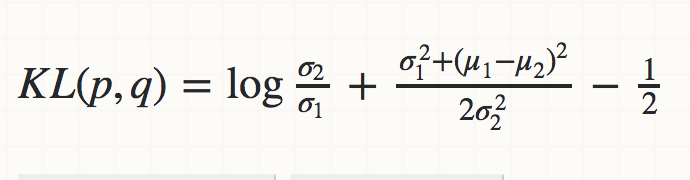

In [ ]:
def main(freq, intv):
    # with open("Beacon Log", "a+") as file:
    #     file.writelines('\n' + str(freq) + ', ' + str(intv) + ': \n')

    train_files = []
    for i in range(1, 13):
        train_files.append('horusrssi/' + str(freq) + 'dBm' + str(intv) + 'secRssi' + str(i) + '.txt')

    test_file = 'traceRssi' + str(freq) + 'dB' + str(intv) + 'sec1.txt'

    state_loc = get_state_location()
    state_map = train(train_files)

    jud = np.zeros(60)

    
    ###################################
    if freq == -12 and intv == 1:
        iter = np.array([4, 18, 21, 50, 59, 46, 11, 28, 22, 39 ])
        jud[iter] = 1
                                                                    # Hard code some beacons to ignore.
    if freq == -15 and intv == 0.1:
        iter = np.array([44, 36, 38, 53])
        jud[iter] = 1
    ##################################

# Whether to ignore some beacons lost in training stage, but doesn't make difference in KL case.
#     for i in range(12):
#         cur = state_map[i]
#         for j in range(60):
#             if cur[j][0] == -100:
#                 jud[j] = 1
                # with open("Beacon Log", "a+") as file:
                #     file.writelines('State '+str(i+1)+ ', loc: (' + str(state_loc[i][0])+ ', ' + str(state_loc[i][1]) + ') Beacon '+str(j) + '\n')
                # print('State '+str(i+1)+ ', loc: (' + str(state_loc[i][0])+ ', ' + str(state_loc[i][1]) + ') Beacon '+str(j))

    d, max_time = cluster_test_data(test_file)
    pred_loc = np.zeros((len(d), 2))

    for index in d:
        res = test_kl(state_map, d[index], state_loc, index, jud)
        pred_loc[index-1][0] = res[0]
        pred_loc[index-1][1] = res[1]

    trueLoc = np.zeros((int(max_time / 10), 2))

    for i in range(int(max_time / 10)):
        cur = gtl.findActualLocation(startTime=10*(i), endTime=10*(i+1), stopTime=10, maxTime=max_time)
        trueLoc[i][0], trueLoc[i][1] = cur[0], cur[1]

    valid_x = 1 - (trueLoc[:,0] < 4) - (trueLoc[:,0] > 8) # X and Y coordinates to ignore
    valid_y = trueLoc[:,1] < 4
    
    valid_loc = valid_x * valid_y
    errors = valid_loc * np.linalg.norm(pred_loc - trueLoc, axis = 1)
    avg_error = np.sum(errors) / np.sum(valid_loc)

    # with open("Erro Log", "a+") as file:
    #     file.writelines('Frequency: ' + str(freq) + ', time interval: ' + str(intv) + ', error: ' + str(avg_error) + '\n')

    print('Frequency: ' + str(freq) + ', time interval: ' + str(intv) + ', error: ' + str(avg_error) )


In [ ]:
freqs = [-12, -15, -20]
intvs = [0.1, 0.5, 1]

for freq in freqs:
    for intv in intvs:
        main(freq, intv)